In [15]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import os
from tqdm.notebook import tqdm
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

os.makedirs('./processed_data', exist_ok=True)

In [23]:
def load_datasets(data_path='../data'):
    """
    Load All Dataset
    """
    datasets = {}
    
    print("Begin Load dataset...")
    
    # define dataset information
    files = {
        'chip': 'chip_dataset.csv',
        'cpu': 'CPU_benchmark_v4.csv',
        'ram': 'RAM_Benchmarks_megalist.csv',
        'r23': 'CPU_r23_v2.csv'
    }
    
    # load dataset
    for name, filename in tqdm(files.items(), desc="Load Dataset"):
        try:
            filepath = os.path.join(data_path, filename)
            datasets[name] = pd.read_csv(filepath)
            print(f"{name}: {datasets[name].shape[0]:,} rows, {datasets[name].shape[1]} columns")
        except Exception as e:
            print(f"Loading {name} failed: {str(e)}")
            
    total_records = sum(df.shape[0] for df in datasets.values())
    print(f"\n Total data volume: {total_records:,} records")
    
    return datasets

datasets = load_datasets()

# Assign to separate variables
df_chip = datasets['chip']
df_cpu = datasets['cpu']
df_ram = datasets['ram']
df_r23 = datasets['r23']

Begin Load dataset...


Load Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

chip: 4,854 rows, 14 columns
cpu: 3,825 rows, 12 columns
ram: 10,855 rows, 6 columns
r23: 215 rows, 9 columns

 Total data volume: 19,749 records


In [27]:
def data_quality_check(df, name):
    """
    Check the quality of individual datasets
    """
    print(f"\n{'='*50}")
    print(f"\t {name.upper()} check data quality")
    print(f"{'='*50}")
    
    # 基本信息
    print(f"\n1. Basic information:")
    print(f"   - rows: {df.shape[0]:,}")
    print(f"   - columns: {df.shape[1]}")
    print(f"   - memory: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # 数据类型
    print(f"\n2. Data type distribution:")
    print(df.dtypes.value_counts())
    
    # 缺失值
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing count': missing,
        'Missing ratio(%)': missing_pct
    })
    missing_df = missing_df[missing_df['Missing count'] > 0].sort_values('Missing count', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n3. Missing value situation:")
        display(missing_df.style.background_gradient(cmap='Reds'))
    else:
        print(f"\n3. No missing values")
    
    # 重复值
    duplicates = df.duplicated().sum()
    print(f"\n4. Duplicate records: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    # head 3 rows
    print(f"\n5. Data preview:")
    display(df.head(3))
    
    return missing_df

# 检查所有数据集
quality_reports = {}
for name, df in datasets.items():
    quality_reports[name] = data_quality_check(df, name)


	 CHIP check data quality

1. Basic information:
   - rows: 4,854
   - columns: 14
   - memory: 0.52 MB

2. Data type distribution:
float64    8
object     5
int64      1
Name: count, dtype: int64

3. Missing value situation:


,Missing count,Missing ratio(%)
FP16 GFLOPS,4318,88.957561
FP64 GFLOPS,3548,73.094355
FP32 GFLOPS,2906,59.868150
Die Size (mm^2),715,14.730119
Transistors (million),711,14.647713
TDP (W),626,12.896580
Process Size (nm),9,0.185414



4. Duplicate records: 0 (0.00%)

5. Data preview:


,Unnamed: 0,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN



	 CPU check data quality

1. Basic information:
   - rows: 3,825
   - columns: 12
   - memory: 0.35 MB

2. Data type distribution:
object     4
float64    4
int64      4
Name: count, dtype: int64

3. Missing value situation:


,Missing count,Missing ratio(%)
price,1858,48.575163
cpuValue,1858,48.575163
threadValue,1858,48.575163
TDP,685,17.908497
powerPerf,685,17.908497



4. Duplicate records: 0 (0.00%)

5. Data preview:


,cpuName,price,cpuMark,cpuValue,threadMark,threadValue,TDP,powerPerf,cores,testDate,socket,category
0,AMD Ryzen Threadripper PRO 5995WX,NaN,108822,NaN,3330,NaN,280.0,388.65,64,2022,sWRX8,Desktop
1,AMD EPYC 7763,7299.99,88338,12.1,2635,0.36,280.0,315.49,64,2021,SP3,Server
2,AMD EPYC 7J13,NaN,86006,NaN,2387,NaN,NaN,NaN,64,2021,unknown,Server



	 RAM check data quality

1. Basic information:
   - rows: 10,855
   - columns: 6
   - memory: 0.50 MB

2. Data type distribution:
float64    3
object     2
int64      1
Name: count, dtype: int64

3. Missing value situation:


,Missing count,Missing ratio(%)
price,9399,86.586826



4. Duplicate records: 0 (0.00%)

5. Data preview:


,memoryName,gen,latency,readUncached,write,price
0,Kingston KF556C40-32 32GB,DDR5,44,21600.0,18100.0,NaN
1,G Skill Intl F5-6400J3239G16G 16GB,DDR5,31,19500.0,16700.0,909.98
2,G Skill Intl F5-5600J3636C16G 16GB,DDR5,42,19400.0,16300.0,627.98



	 R23 check data quality

1. Basic information:
   - rows: 215
   - columns: 9
   - memory: 0.01 MB

2. Data type distribution:
int64      4
object     3
float64    2
Name: count, dtype: int64

3. No missing values

4. Duplicate records: 0 (0.00%)

5. Data preview:


,manufacturer,cpuName,singleScore,multiScore,cores,threads,baseClock,turboClock,type
0,AMD,Threadripper 3990X,1262,75671,64,128,2.9,4.50,Desktop
1,AMD,Threadripper Pro 3995WX,1231,73220,64,128,2.7,4.20,Desktop
2,AMD,Epyc 7702P,993,48959,64,128,2.0,3.35,Desktop


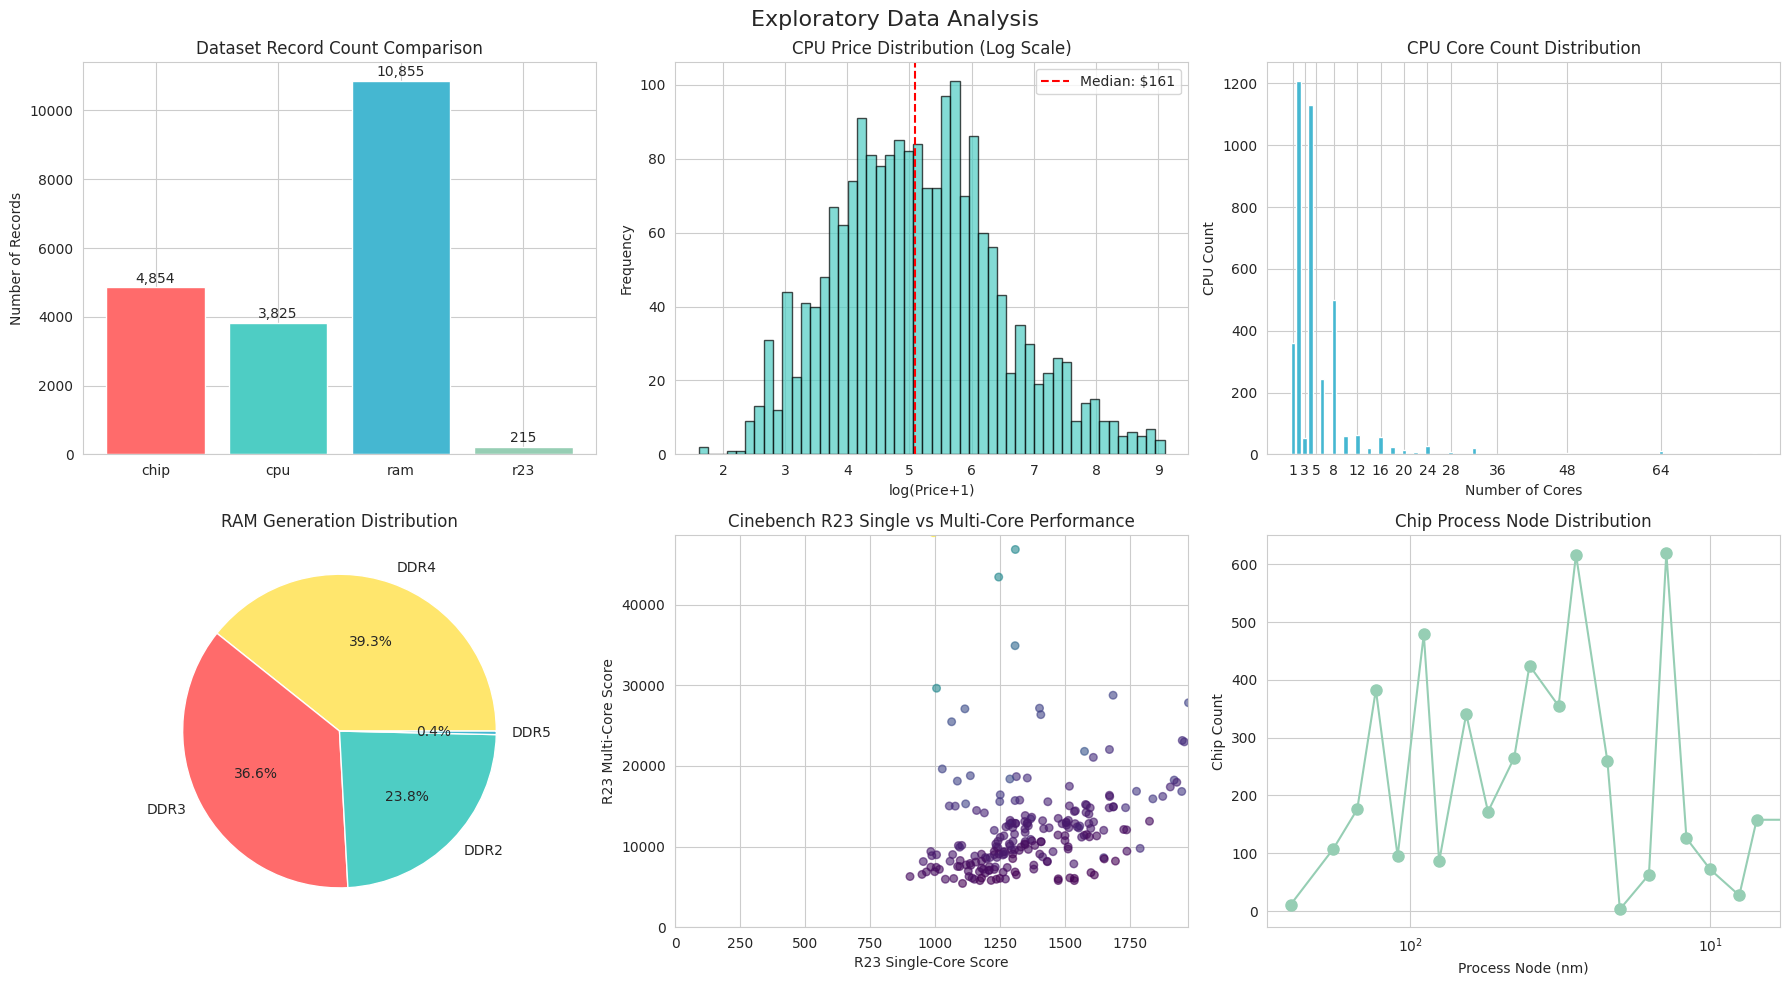

In [28]:
# Create exploratory data visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16)

# 1. Dataset size comparison
ax = axes[0, 0]
sizes = [len(df) for df in datasets.values()]
names = list(datasets.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax.bar(names, sizes, color=colors)
ax.set_title('Dataset Record Count Comparison')
ax.set_ylabel('Number of Records')
for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{size:,}', ha='center', va='bottom')

# 2. CPU price distribution
ax = axes[0, 1]
cpu_prices = df_cpu['price'].dropna()
ax.hist(np.log1p(cpu_prices), bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
ax.set_title('CPU Price Distribution (Log Scale)')
ax.set_xlabel('log(Price+1)')
ax.set_ylabel('Frequency')
ax.axvline(np.log1p(cpu_prices.median()), color='red', linestyle='--', 
          label=f'Median: ${cpu_prices.median():.0f}')
ax.legend()

# 3. CPU core count distribution
ax = axes[0, 2]
core_counts = df_cpu['cores'].value_counts().sort_index()
ax.bar(core_counts.index, core_counts.values, color='#45B7D1')
ax.set_title('CPU Core Count Distribution')
ax.set_xlabel('Number of Cores')
ax.set_ylabel('CPU Count')
ax.set_xticks(core_counts.index[::2])  # Show every other tick

# 4. RAM generation distribution
ax = axes[1, 0]
ram_gen = df_ram['gen'].value_counts()
ax.pie(ram_gen.values, labels=ram_gen.index, autopct='%1.1f%%', 
       colors=['#FFE66D', '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax.set_title('RAM Generation Distribution')

# 5. R23 benchmark - Single vs Multi-core performance
ax = axes[1, 1]
ax.scatter(df_r23['singleScore'], df_r23['multiScore'], 
          alpha=0.6, s=30, c=df_r23['cores'], cmap='viridis')
ax.set_xlabel('R23 Single-Core Score')
ax.set_ylabel('R23 Multi-Core Score')
ax.set_title('Cinebench R23 Single vs Multi-Core Performance')
ax.set_xlim(0, df_r23['singleScore'].quantile(0.99))
ax.set_ylim(0, df_r23['multiScore'].quantile(0.99))

# 6. Chip process node trend
ax = axes[1, 2]
process_sizes = df_chip['Process Size (nm)'].value_counts().sort_index()
ax.plot(process_sizes.index, process_sizes.values, 'o-', color='#96CEB4', markersize=8)
ax.set_title('Chip Process Node Distribution')
ax.set_xlabel('Process Node (nm)')
ax.set_ylabel('Chip Count')
ax.set_xscale('log')
ax.invert_xaxis()  # Smaller process is more advanced

plt.tight_layout()
plt.show()

In [31]:
def clean_cpu_name(name):
    """
    Clean CPU names for matching
    """
    if pd.isna(name):
        return ""
    
    name = str(name).strip()
    
    # Standardize brand names
    name = re.sub(r'Intel\s*Core\s*', 'Intel Core ', name, flags=re.IGNORECASE)
    name = re.sub(r'AMD\s*Ryzen\s*', 'AMD Ryzen ', name, flags=re.IGNORECASE)
    
    # Remove frequency information
    name = re.sub(r'@\s*\d+\.?\d*\s*[GM]Hz', '', name, flags=re.IGNORECASE)
    
    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name)
    
    # Standardize model format
    name = re.sub(r'i(\d)-(\d+)', r'i\1-\2', name)  # i7 1234 -> i7-1234
    name = re.sub(r'Ryzen\s+(\d)\s+(\d+)', r'Ryzen \1 \2', name)  # Ryzen 7 5800X
    
    return name.strip()

# Test cleaning function
test_names = [
    "Intel Core i7-12700K @ 3.6GHz",
    "AMD Ryzen 9  5900X",
    "Intel  Core  i5 12400",
    "Apple M1 Pro"
]

print("CPU name cleaning:")
for original in test_names:
    cleaned = clean_cpu_name(original)
    print(f"{original:<35} -> {cleaned}")

CPU name cleaning:
Intel Core i7-12700K @ 3.6GHz       -> Intel Core i7-12700K
AMD Ryzen 9  5900X                  -> AMD Ryzen 9 5900X
Intel  Core  i5 12400               -> Intel Core i5 12400
Apple M1 Pro                        -> Apple M1 Pro


In [32]:
def handle_missing_values(df_chip, df_cpu, df_ram, df_r23):
    """
    handle missing values of all datasets
    """
    print(" Begin handle all missing values...")
    
    # 1. 芯片数据
    print("\n1. 处理芯片数据缺失值...")
    chip_numeric_cols = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 
                        'Transistors (million)', 'Freq (MHz)', 
                        'FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS']
    
    chip_missing_before = df_chip[chip_numeric_cols].isnull().sum().sum()
    
    if chip_missing_before > 0:
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        chip_imputed = pd.DataFrame(
            imputer.fit_transform(df_chip[chip_numeric_cols]),
            columns=chip_numeric_cols,
            index=df_chip.index
        )
        df_chip[chip_numeric_cols] = chip_imputed
        print(f"   使用KNN填充了 {chip_missing_before} 个缺失值")
    
    # 2. CPU数据
    print("\n2. 处理CPU数据缺失值...")
    
    # 价格缺失值
    price_missing = df_cpu['price'].isnull().sum()
    if price_missing > 0:
        df_cpu['price'] = df_cpu.groupby(['cores'])['price'].transform(
            lambda x: x.fillna(x.median())
        )
        df_cpu['price'].fillna(df_cpu['price'].median(), inplace=True)
        print(f"   填充了 {price_missing} 个价格缺失值")
    
    # TDP缺失值
    tdp_missing = df_cpu['TDP'].isnull().sum()
    if tdp_missing > 0:
        # 基于核心数的典型TDP
        tdp_map = {
            2: 35, 4: 65, 6: 65, 8: 95, 
            10: 125, 12: 125, 16: 165, 
            24: 200, 32: 250, 64: 280
        }
        
        def estimate_tdp(row):
            if pd.isna(row['TDP']):
                cores = row['cores']
                # 找最接近的核心数
                closest_cores = min(tdp_map.keys(), key=lambda x: abs(x - cores))
                return tdp_map[closest_cores]
            return row['TDP']
        
        df_cpu['TDP'] = df_cpu.apply(estimate_tdp, axis=1)
        print(f"   填充了 {tdp_missing} 个TDP缺失值")
    
    # 3. 内存数据
    print("\n3. 处理内存数据缺失值...")
    ram_price_missing = df_ram['price'].isnull().sum()
    if ram_price_missing > 0:
        df_ram['price'] = df_ram.groupby('gen')['price'].transform(
            lambda x: x.fillna(x.median())
        )
        df_ram['price'].fillna(df_ram['price'].median(), inplace=True)
        print(f"   填充了 {ram_price_missing} 个内存价格缺失值")
    
    # 4. R23数据
    print("\n4. 处理R23数据缺失值...")
    freq_missing = df_r23[['baseClock', 'turboClock']].isnull().sum().sum()
    if freq_missing > 0:
        df_r23['baseClock'].fillna(df_r23['baseClock'].median(), inplace=True)
        df_r23['turboClock'].fillna(df_r23['turboClock'].median(), inplace=True)
        print(f"   填充了 {freq_missing} 个频率缺失值")
    
    print("\n 缺失值处理完成!")
    
    return df_chip, df_cpu, df_ram, df_r23

# 处理缺失值
df_chip, df_cpu, df_ram, df_r23 = handle_missing_values(df_chip, df_cpu, df_ram, df_r23)

 Begin handle all missing values...

1. 处理芯片数据缺失值...
   使用KNN填充了 12833 个缺失值

2. 处理CPU数据缺失值...
   填充了 1858 个价格缺失值
   填充了 685 个TDP缺失值

3. 处理内存数据缺失值...
   填充了 9399 个内存价格缺失值

4. 处理R23数据缺失值...

 缺失值处理完成!


In [33]:
def create_features(df_chip, df_cpu, df_ram, df_r23):
    """
    为所有数据集创建新特征
    """
    print(" 开始特征工程...")
    
    # 1. 芯片特征
    print("\n1. 创建芯片特征...")
    df_chip['transistor_density'] = (
        df_chip['Transistors (million)'] / df_chip['Die Size (mm^2)']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_chip['gflops_per_watt'] = (
        df_chip['FP32 GFLOPS'] / df_chip['TDP (W)']
    ).replace([np.inf, -np.inf], np.nan)
    
    # 制程代际映射
    process_gen_map = {
        5: 6, 7: 5, 10: 4, 14: 3, 
        16: 3, 22: 2, 28: 2, 32: 1, 
        45: 1, 65: 0, 90: 0
    }
    df_chip['process_generation'] = df_chip['Process Size (nm)'].map(
        lambda x: process_gen_map.get(int(x), 0) if pd.notna(x) else 0
    )
    
    # 2. CPU特征
    print("2. 创建CPU特征...")
    
    # 性能相关
    df_cpu['performance_per_core'] = (
        df_cpu['cpuMark'] / df_cpu['cores']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_cpu['performance_per_watt'] = (
        df_cpu['cpuMark'] / df_cpu['TDP']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_cpu['thread_efficiency'] = (
        df_cpu['threadMark'] / (df_cpu['cpuMark'] / df_cpu['cores'])
    ).replace([np.inf, -np.inf], np.nan).fillna(1)
    
    # 提取品牌
    def extract_brand(name):
        name_str = str(name).upper()
        if 'INTEL' in name_str:
            return 'Intel'
        elif 'AMD' in name_str or 'RYZEN' in name_str:
            return 'AMD'
        elif 'APPLE' in name_str or 'M1' in name_str or 'M2' in name_str:
            return 'Apple'
        else:
            return 'Other'
    
    df_cpu['brand'] = df_cpu['cpuName'].apply(extract_brand)
    
    # 3. 内存特征
    print("3. 创建内存特征...")
    
    # 性能分数
    df_ram['perf_score'] = (
        (df_ram['readUncached'] + df_ram['write']) / 
        (df_ram['latency'] + 1)
    ).replace([np.inf, -np.inf], np.nan)
    
    # 性价比
    df_ram['value_score'] = (
        df_ram['perf_score'] / (df_ram['price'] + 1)
    ).replace([np.inf, -np.inf], np.nan)
    
    # 内存代际数值化
    gen_map = {'DDR': 1, 'DDR2': 2, 'DDR3': 3, 'DDR4': 4, 'DDR5': 5}
    df_ram['gen_numeric'] = df_ram['gen'].map(gen_map).fillna(0)
    
    # 4. R23特征
    print("4. 创建R23特征...")
    
    # 频率相关
    df_r23['boost_headroom'] = (
        (df_r23['turboClock'] - df_r23['baseClock']) / df_r23['baseClock']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_r23['smt_efficiency'] = (df_r23['threads'] / df_r23['cores']).fillna(1)
    
    # 性能效率
    df_r23['single_efficiency'] = (
        df_r23['singleScore'] / df_r23['turboClock']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_r23['scaling_efficiency'] = (
        df_r23['multiScore'] / (df_r23['singleScore'] * df_r23['cores'])
    ).replace([np.inf, -np.inf], np.nan)
    
    print("\n 特征工程完成!")
    
    # 显示新特征统计
    print("\n新特征统计:")
    print(f"- 芯片晶体管密度范围: {df_chip['transistor_density'].min():.1f} - {df_chip['transistor_density'].max():.1f}")
    print(f"- CPU每核性能范围: {df_cpu['performance_per_core'].min():.0f} - {df_cpu['performance_per_core'].max():.0f}")
    print(f"- 内存性能分数范围: {df_ram['perf_score'].min():.1f} - {df_ram['perf_score'].max():.1f}")
    print(f"- R23单核效率范围: {df_r23['single_efficiency'].min():.1f} - {df_r23['single_efficiency'].max():.1f}")
    
    return df_chip, df_cpu, df_ram, df_r23

# 执行特征工程
df_chip, df_cpu, df_ram, df_r23 = create_features(df_chip, df_cpu, df_ram, df_r23)

 开始特征工程...

1. 创建芯片特征...
2. 创建CPU特征...
3. 创建内存特征...
4. 创建R23特征...

 特征工程完成!

新特征统计:
- 芯片晶体管密度范围: 0.1 - 154.0
- CPU每核性能范围: 46 - 6771
- 内存性能分数范围: 4.5 - 3080.0
- R23单核效率范围: 231.1 - 491.9


In [34]:
def match_cpu_datasets(df_cpu, df_r23):
    """
    使用模糊匹配合并CPU基准数据和R23数据
    """
    print(" 开始匹配CPU数据集...")
    
    # 清理CPU名称
    print("\n1. 清理CPU名称...")
    df_cpu['cpu_name_clean'] = df_cpu['cpuName'].apply(clean_cpu_name)
    df_r23['cpu_name_clean'] = df_r23['cpuName'].apply(clean_cpu_name)
    
    # 为加快匹配速度，先尝试精确匹配
    print("\n2. 尝试精确匹配...")
    exact_matches = pd.merge(
        df_r23[['cpu_name_clean']].reset_index().rename(columns={'index': 'r23_idx'}),
        df_cpu[['cpu_name_clean']].reset_index().rename(columns={'index': 'cpu_idx'}),
        on='cpu_name_clean',
        how='inner'
    )
    
    print(f"    精确匹配: {len(exact_matches)} 个")
    
    # 对未匹配的进行模糊匹配
    unmatched_r23_idx = set(range(len(df_r23))) - set(exact_matches['r23_idx'])
    
    print(f"\n3. 对剩余 {len(unmatched_r23_idx)} 个CPU进行模糊匹配...")
    
    fuzzy_matches = []
    unmatched_list = []
    
    # 使用进度条
    for idx in tqdm(unmatched_r23_idx, desc="模糊匹配"):
        r23_name = df_r23.loc[idx, 'cpu_name_clean']
        
        if not r23_name:
            continue
        
        # 查找最佳匹配
        best_match = process.extractOne(
            r23_name, 
            df_cpu['cpu_name_clean'].tolist(),
            scorer=fuzz.ratio
        )
        
        if best_match and best_match[1] >= 80:  # 80%相似度阈值
            cpu_matches = df_cpu[df_cpu['cpu_name_clean'] == best_match[0]]
            if not cpu_matches.empty:
                cpu_idx = cpu_matches.index[0]
                fuzzy_matches.append({
                    'r23_idx': idx,
                    'cpu_idx': cpu_idx,
                    'similarity': best_match[1]
                })
        else:
            unmatched_list.append({
                'r23_idx': idx,
                'r23_name': df_r23.loc[idx, 'cpuName'],
                'best_match': best_match[0] if best_match else None,
                'similarity': best_match[1] if best_match else 0
            })
    
    print(f"    模糊匹配: {len(fuzzy_matches)} 个")
    
    # 合并所有匹配
    all_matches = []
    
    # 添加精确匹配
    for _, row in exact_matches.iterrows():
        all_matches.append({
            'r23_idx': row['r23_idx'],
            'cpu_idx': row['cpu_idx'],
            'similarity': 100
        })
    
    # 添加模糊匹配
    all_matches.extend(fuzzy_matches)
    
    print(f"\n 匹配结果汇总:")
    print(f"   - 总R23记录: {len(df_r23)}")
    print(f"   - 成功匹配: {len(all_matches)} ({len(all_matches)/len(df_r23)*100:.1f}%)")
    print(f"   - 未匹配: {len(unmatched_list)} ({len(unmatched_list)/len(df_r23)*100:.1f}%)")
    
    return all_matches, unmatched_list

# 执行匹配
matches, unmatched = match_cpu_datasets(df_cpu, df_r23)

# 显示部分匹配结果
print("\n匹配示例:")
match_df = pd.DataFrame(matches[:5])
match_df['r23_name'] = match_df['r23_idx'].apply(lambda x: df_r23.loc[x, 'cpuName'])
match_df['cpu_name'] = match_df['cpu_idx'].apply(lambda x: df_cpu.loc[x, 'cpuName'])
display(match_df[['r23_name', 'cpu_name', 'similarity']])

 开始匹配CPU数据集...

1. 清理CPU名称...

2. 尝试精确匹配...
    精确匹配: 0 个

3. 对剩余 215 个CPU进行模糊匹配...


模糊匹配:   0%|          | 0/215 [00:00<?, ?it/s]

    模糊匹配: 203 个

 匹配结果汇总:
   - 总R23记录: 215
   - 成功匹配: 203 (94.4%)
   - 未匹配: 12 (5.6%)

匹配示例:


,r23_name,cpu_name,similarity
0,Threadripper Pro 3995WX,AMD Ryzen Threadripper PRO 3995WX,82
1,Epyc 7702P,AMD EPYC 7702P,83
2,Threadripper Pro 3975WX,AMD Ryzen Threadripper PRO 3975WX,82
3,Ryzen 9 5950X,AMD Ryzen 9 5950X,87
4,Core i9 12900K,Intel Core i9-12900K,82


In [35]:
def create_merged_dataset(df_cpu, df_r23, matches):
    """
    创建合并后的CPU数据集
    """
    print(" 创建合并数据集...")
    
    # 复制CPU数据集
    df_merged = df_cpu.copy()
    
    # 添加R23相关列
    r23_columns = ['singleScore', 'multiScore', 'baseClock', 'turboClock',
                   'boost_headroom', 'smt_efficiency', 'single_efficiency', 
                   'scaling_efficiency']
    
    for col in r23_columns:
        df_merged[col] = np.nan
    
    # 填充匹配的数据
    print(f"\n填充 {len(matches)} 条匹配数据...")
    
    for match in tqdm(matches, desc="合并数据"):
        r23_idx = match['r23_idx']
        cpu_idx = match['cpu_idx']
        
        # 复制R23数据
        for col in r23_columns:
            if col in df_r23.columns:
                df_merged.loc[cpu_idx, col] = df_r23.loc[r23_idx, col]
    
    # 创建综合性能指标
    print("\n创建综合性能指标...")
    
    # 游戏性能（单核权重高）
    df_merged['gaming_score'] = np.where(
        df_merged['singleScore'].notna(),
        0.7 * df_merged['singleScore'] + 0.3 * df_merged['multiScore'],
        df_merged['threadMark']
    )
    
    # 生产力性能（多核权重高）
    df_merged['productivity_score'] = np.where(
        df_merged['multiScore'].notna(),
        0.3 * df_merged['singleScore'] + 0.7 * df_merged['multiScore'],
        df_merged['cpuMark']
    )
    
    # 综合性能
    df_merged['combined_score'] = np.where(
        df_merged['singleScore'].notna(),
        0.5 * df_merged['singleScore'] + 0.5 * df_merged['multiScore'],
        df_merged['cpuMark']
    )
    
    # 性价比指标
    df_merged['r23_per_dollar'] = (
        df_merged['multiScore'] / df_merged['price']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_merged['gaming_value'] = (
        df_merged['gaming_score'] / df_merged['price']
    ).replace([np.inf, -np.inf], np.nan)
    
    df_merged['productivity_value'] = (
        df_merged['productivity_score'] / df_merged['price']
    ).replace([np.inf, -np.inf], np.nan)
    
    # 显示合并结果统计
    print(f"\n 合并完成!")
    print(f"   - 总CPU数: {len(df_merged)}")
    print(f"   - 有R23数据: {df_merged['singleScore'].notna().sum()} ({df_merged['singleScore'].notna().sum()/len(df_merged)*100:.1f}%)")
    
    return df_merged

# 创建合并数据集
df_merged = create_merged_dataset(df_cpu, df_r23, matches)

# 显示部分合并结果
print("\n合并数据预览:")
cols_to_show = ['cpuName', 'price', 'cpuMark', 'singleScore', 'multiScore', 'gaming_score', 'productivity_score']
display(df_merged[df_merged['singleScore'].notna()][cols_to_show].head())

 创建合并数据集...

填充 203 条匹配数据...


合并数据:   0%|          | 0/203 [00:00<?, ?it/s]


创建综合性能指标...

 合并完成!
   - 总CPU数: 3825
   - 有R23数据: 198 (5.2%)

合并数据预览:


,cpuName,price,cpuMark,singleScore,multiScore,gaming_score,productivity_score
4,AMD Ryzen Threadripper PRO 3995WX,6807.98,83971,1231.0,73220.0,22827.7,51623.3
18,AMD Ryzen Threadripper PRO 3975WX,4499.99,63495,1244.0,43450.0,13905.8,30788.2
20,AMD EPYC 7702P,3499.99,61689,993.0,48959.0,15382.8,34569.2
39,AMD Ryzen 9 5950X,649.74,46195,1684.0,28782.0,9813.4,20652.6
44,Intel Core i9-12900KS,779.98,44243,2082.0,27796.0,9796.2,20081.8


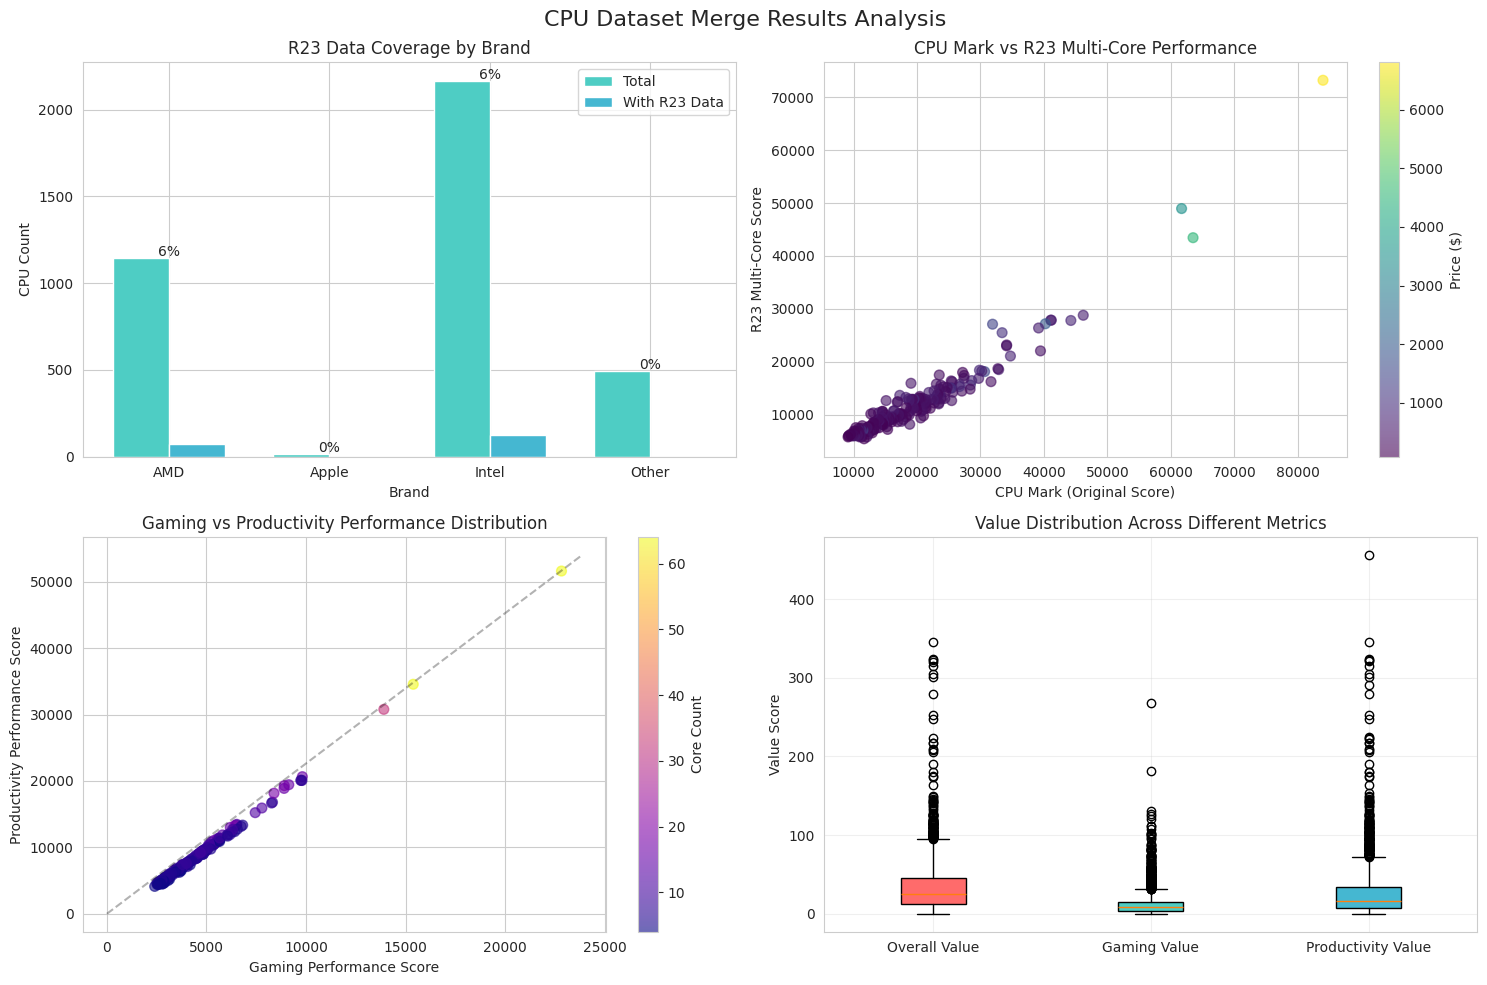

In [36]:
# Create visualization analysis of merged data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('CPU Dataset Merge Results Analysis', fontsize=16)

# 1. R23 data coverage by brand
ax = axes[0, 0]
coverage_by_brand = df_merged.groupby('brand').agg({
    'cpuName': 'count',
    'singleScore': lambda x: x.notna().sum()
}).rename(columns={'cpuName': 'total', 'singleScore': 'with_r23'})
coverage_by_brand['coverage_rate'] = coverage_by_brand['with_r23'] / coverage_by_brand['total'] * 100

x = np.arange(len(coverage_by_brand))
width = 0.35
bars1 = ax.bar(x - width/2, coverage_by_brand['total'], width, label='Total', color='#4ECDC4')
bars2 = ax.bar(x + width/2, coverage_by_brand['with_r23'], width, label='With R23 Data', color='#45B7D1')

ax.set_xlabel('Brand')
ax.set_ylabel('CPU Count')
ax.set_title('R23 Data Coverage by Brand')
ax.set_xticks(x)
ax.set_xticklabels(coverage_by_brand.index)
ax.legend()

# Add coverage rate labels
for i, (idx, row) in enumerate(coverage_by_brand.iterrows()):
    ax.text(i, row['total'] + 10, f"{row['coverage_rate']:.0f}%", ha='center')

# 2. Performance score comparison
ax = axes[0, 1]
merged_with_r23 = df_merged[df_merged['singleScore'].notna()]
ax.scatter(merged_with_r23['cpuMark'], merged_with_r23['multiScore'], 
          alpha=0.6, s=50, c=merged_with_r23['price'], cmap='viridis')
ax.set_xlabel('CPU Mark (Original Score)')
ax.set_ylabel('R23 Multi-Core Score')
ax.set_title('CPU Mark vs R23 Multi-Core Performance')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Price ($)')

# 3. Gaming vs Productivity performance
ax = axes[1, 0]
ax.scatter(merged_with_r23['gaming_score'], merged_with_r23['productivity_score'],
          alpha=0.6, s=50, c=merged_with_r23['cores'], cmap='plasma')
ax.set_xlabel('Gaming Performance Score')
ax.set_ylabel('Productivity Performance Score')
ax.set_title('Gaming vs Productivity Performance Distribution')
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], 'k--', alpha=0.3)  # Diagonal line
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Core Count')

# 4. Value distribution
ax = axes[1, 1]
value_metrics = ['cpuValue', 'gaming_value', 'productivity_value']
value_data = [df_merged[col].dropna() for col in value_metrics]
value_labels = ['Overall Value', 'Gaming Value', 'Productivity Value']

bp = ax.boxplot(value_data, labels=value_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Value Score')
ax.set_title('Value Distribution Across Different Metrics')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
def save_processed_data(df_chip, df_cpu, df_ram, df_merged, matches, unmatched):
    """
    Save all processed data
    """
    print(" Saving processed data...")
    
    output_dir = './processed_data/'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save main datasets
    datasets_to_save = {
        'chip_processed.csv': df_chip,
        'cpu_processed.csv': df_cpu,
        'ram_processed.csv': df_ram,
        'cpu_merged.csv': df_merged
    }
    
    for filename, df in datasets_to_save.items():
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)
        print(f"   ✓ {filename} - {df.shape[0]:,} rows")
    
    # Save match results
    match_df = pd.DataFrame(matches)
    match_df['r23_name'] = match_df['r23_idx'].apply(lambda x: df_r23.loc[x, 'cpuName'])
    match_df['cpu_name'] = match_df['cpu_idx'].apply(lambda x: df_cpu.loc[x, 'cpuName'])
    match_df.to_csv(os.path.join(output_dir, 'match_details.csv'), index=False)
    
    # Save unmatched records
    unmatched_df = pd.DataFrame(unmatched)
    unmatched_df.to_csv(os.path.join(output_dir, 'unmatched_r23.csv'), index=False)
    
    # Save processing report
    report = {
        'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'original_sizes': {
            'chip': df_chip.shape,
            'cpu': df_cpu.shape,
            'ram': df_ram.shape,
            'r23': df_r23.shape
        },
        'match_statistics': {
            'total_r23': len(df_r23),
            'matched': len(matches),
            'unmatched': len(unmatched),
            'match_rate': len(matches) / len(df_r23) * 100
        },
        'merged_statistics': {
            'total_cpus': len(df_merged),
            'cpus_with_r23': df_merged['singleScore'].notna().sum(),
            'coverage_rate': df_merged['singleScore'].notna().sum() / len(df_merged) * 100
        }
    }
    
    # Save as pickle for later use
    all_data = {
        'chip': df_chip,
        'cpu': df_cpu,
        'ram': df_ram,
        'merged': df_merged,
        'matches': matches,
        'unmatched': unmatched,
        'report': report
    }
    
    with open(os.path.join(output_dir, 'all_processed_data.pkl'), 'wb') as f:
        pickle.dump(all_data, f)
    
    print(f"\n All data saved to: {output_dir}")
    
    return report

# Save data
report = save_processed_data(df_chip, df_cpu, df_ram, df_merged, matches, unmatched)

# Display processing report
print("\n" + "="*50)
print(" Data Processing Report")
print("="*50)
print(f"Processing time: {report['processing_date']}")
print(f"\nOriginal data sizes:")
for name, shape in report['original_sizes'].items():
    print(f"   - {name}: {shape[0]:,} rows, {shape[1]} columns")
print(f"\nMatching statistics:")
for key, value in report['match_statistics'].items():
    if isinstance(value, float):
        print(f"   - {key}: {value:.1f}%")
    else:
        print(f"   - {key}: {value:,}")
print(f"\nMerged data statistics:")
for key, value in report['merged_statistics'].items():
    if isinstance(value, float):
        print(f"   - {key}: {value:.1f}%")
    else:
        print(f"   - {key}: {value:,}")

 Saving processed data...
   ✓ chip_processed.csv - 4,854 rows
   ✓ cpu_processed.csv - 3,825 rows
   ✓ ram_processed.csv - 10,855 rows
   ✓ cpu_merged.csv - 3,825 rows

 All data saved to: ./processed_data/

 Data Processing Report
Processing time: 2025-07-21 10:04:41

Original data sizes:
   - chip: 4,854 rows, 17 columns
   - cpu: 3,825 rows, 17 columns
   - ram: 10,855 rows, 9 columns
   - r23: 215 rows, 14 columns

Matching statistics:
   - total_r23: 215
   - matched: 203
   - unmatched: 12
   - match_rate: 94.4%

Merged data statistics:
   - total_cpus: 3,825
   - cpus_with_r23: 198
   - coverage_rate: 5.2%


In [39]:
# Create final data quality summary
print(" Data Preprocessing Complete Summary")
print("="*60)

# 1. Data completeness
print("\n1. Data Completeness:")
print(f"   - Chip data: {len(df_chip):,} records")
print(f"   - CPU benchmark data: {len(df_cpu):,} records") 
print(f"   - RAM data: {len(df_ram):,} records")
print(f"   - Merged CPU data: {len(df_merged):,} records")

# 2. Feature richness
print("\n2. Feature Richness:")
print(f"   - Chip features: {len(df_chip.columns)}")
print(f"   - CPU features: {len(df_cpu.columns)}")
print(f"   - RAM features: {len(df_ram.columns)}")
print(f"   - Merged CPU features: {len(df_merged.columns)}")

# 3. Key metric ranges
print("\n3. Key Metric Ranges:")
print(f"   - CPU Price: ${df_merged['price'].min():.0f} - ${df_merged['price'].max():.0f}")
print(f"   - CPU Performance: {df_merged['cpuMark'].min():.0f} - {df_merged['cpuMark'].max():.0f}")
print(f"   - R23 Single-Core: {df_merged['singleScore'].min():.0f} - {df_merged['singleScore'].max():.0f}")
print(f"   - R23 Multi-Core: {df_merged['multiScore'].min():.0f} - {df_merged['multiScore'].max():.0f}")

# 4. Next steps
print("\n4. Next Steps:")
print("    Data is ready for:")
print("     - K-means clustering analysis")
print("     - Budget allocation model training")
print("     - Performance prediction model building")
print("     - Recommendation system development")

print("\n Data preprocessing pipeline complete!")

 Data Preprocessing Complete Summary

1. Data Completeness:
   - Chip data: 4,854 records
   - CPU benchmark data: 3,825 records
   - RAM data: 10,855 records
   - Merged CPU data: 3,825 records

2. Feature Richness:
   - Chip features: 17
   - CPU features: 17
   - RAM features: 9
   - Merged CPU features: 31

3. Key Metric Ranges:
   - CPU Price: $4 - $8978
   - CPU Performance: 77 - 108822
   - R23 Single-Core: 903 - 2082
   - R23 Multi-Core: 5423 - 73220

4. Next Steps:
    Data is ready for:
     - K-means clustering analysis
     - Budget allocation model training
     - Performance prediction model building
     - Recommendation system development

 Data preprocessing pipeline complete!
